In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [153]:
df = pd.read_hdf('Giant.h5')

In [154]:
df.head(10)

x         y     theta  tail_angle_01  tail_angle_02  \
frame_id                                                               
103601    73.69724  595.5804  1.661527       0.050498      -0.016440   
103602    73.72903  595.6200  1.660250       0.043642       0.001564   
103603    73.68596  595.6003  1.663265       0.041430      -0.004075   
103604    73.71770  595.6288  1.661963       0.042159      -0.004702   
103605    73.71770  595.6288  1.661723       0.040063      -0.000466   
103606    73.74426  595.6652  1.660766       0.042486      -0.003265   
103607    73.71761  595.8105  1.661348       0.040919       0.005434   
103608    73.74799  595.7083  1.660955       0.043138      -0.005130   
103609    73.74596  595.6342  1.660619       0.046214      -0.007942   
103610    73.73471  595.6542  1.661516       0.038723       0.007027   

          tail_angle_03  tail_angle_04  tail_angle_05  tail_angle_06  \
frame_id                                                               
103601         0.009068      -0.012574      -0.019070       0.046330   
103602         0.002408      -0.029698       0.011411       0.021807   
103603         0.002937      -0.022274       0.012015       0.014713   
103604         0.005740      -0.015064      -0.014538       0.037468   
103605         0.004081      -0.025827       0.005307       0.033360   
103606         0.004266      -0.025068       0.004170       0.036396   
103607        -0.009359      -0.012313      -0.004558       0.030436   
103608         0.008116      -0.023209      -0.006627       0.038300   
103609         0.004954      -0.030293       0.021400       0.015620   
103610        -0.005912      -0.024250       0.012194       0.020117   

          tail_angle_07  ...  tail_value_01  tail_value_02  tail_value_03  \
frame_id                 ...                                                
103601        -0.007306  ...       558.2509       294.4854       235.4711   
103602        -0.001874  ...       563.1628       287.7928       238.8775   
103603         0.002269  ...       564.0679       286.3506       237.1006   
103604        -0.002097  ...       558.5044       286.6552       232.8338   
103605        -0.001918  ...       553.3157       285.1667       238.9282   
103606        -0.009972  ...       552.2186       285.6654       234.5071   
103607        -0.001653  ...       572.7526       288.1426       227.6399   
103608        -0.008463  ...       561.8183       288.2664       233.3537   
103609        -0.005273  ...       546.4205       281.3492       235.9477   
103610         0.000210  ...       547.7566       289.1722       234.5851   

          tail_value_04  tail_value_05  tail_value_06  tail_value_07  \
frame_id                                                               
103601         203.8689       183.4497       137.1873       115.1374   
103602         202.2527       184.4944       136.7738       116.4228   
103603         198.0228       182.5386       136.2459       113.4250   
103604         192.9184       187.4003       139.3187       112.5696   
103605         201.0047       187.9429       137.3472       111.8874   
103606         198.6155       188.8189       141.5963       111.5304   
103607         196.9709       194.3045       143.0983       114.4926   
103608         196.2758       187.9764       143.5434       110.4618   
103609         200.4252       189.7549       140.3379       106.6939   
103610         195.9897       185.0865       138.4738       110.3618   

          tail_value_08  tail_value_09  tail_value_10  
frame_id                                               
103601         83.65917       86.44755       30.16367  
103602         81.63942       81.31573       28.75116  
103603         83.32574       81.35854       24.85457  
103604         84.12813       82.79957       25.64803  
103605         81.48780       81.23280       28.09221  
103606         87.59415       80.97386       24.69491  
103607         84.29243       84.90253       21.9

In [155]:
from AllSegmentationClass import Tail

# use tail value as a mask:
tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,11)]]
tail_angle = tail_angle.values
print(tail_angle.shape)

tail = Tail(tail_angle)
tail.tail_angle_preprocessing()

print('Shape of No Track:')
print(len(tail.notrack_id))

(9232637, 10)
Shape of No Track:
1829


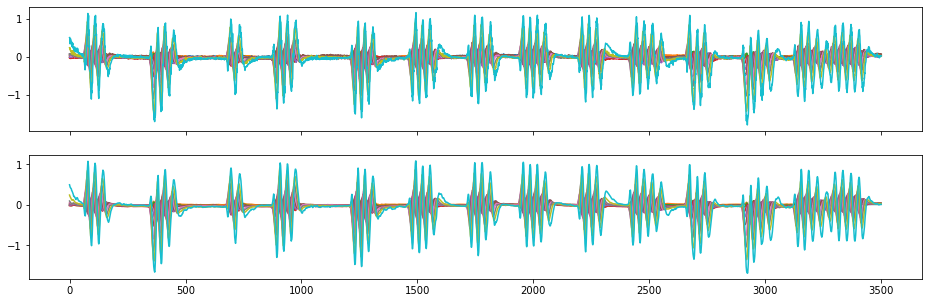

In [156]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(16,5), sharex=True)
ax[0].plot(tail.angle[IdSt:IdSt+Duration,:])
ax[1].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])
plt.show()

In [157]:
from AllSegmentationClass import Binarization

In [158]:
bin = Binarization(tail)

In [159]:
bin.compute_low_pass_speed(win_BC = 10,MinFiltSize=500,MaxFiltSize=20)
bin.compute_noiselevel(win_zscore = 30,win_smoothing = 7, win_med=51)

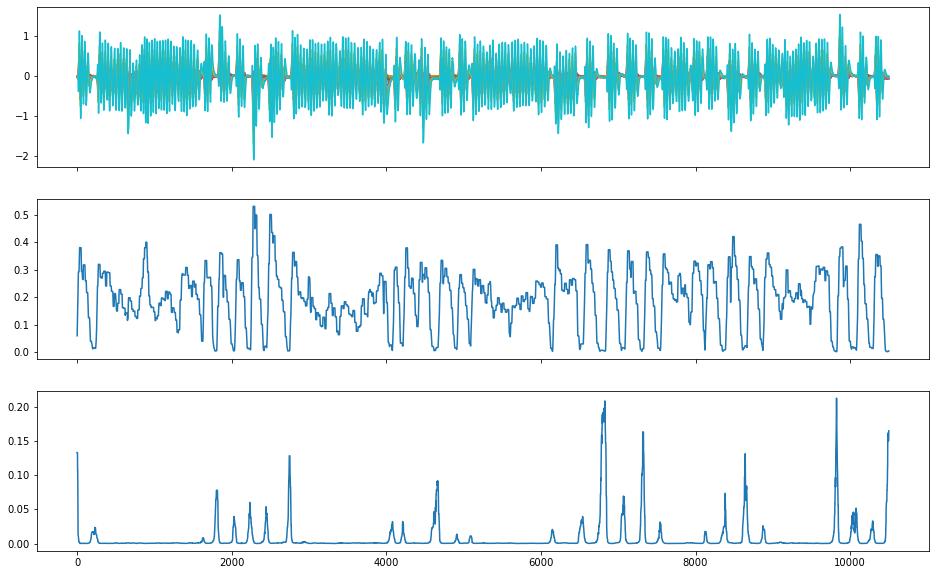

In [160]:
# Diagnostic Plot:
Duration = 700*15
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(3,1,figsize=(16,10), sharex=True)
ax[0].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])

ax[1].plot(bin.low_pass_speed[IdSt:IdSt+Duration])
ax[2].plot(bin.smooth_residual[IdSt:IdSt+Duration])

plt.show()

0.1711127014890422


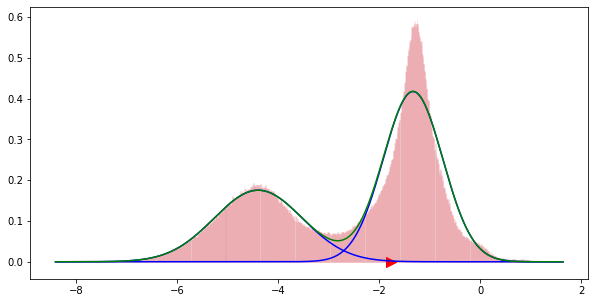

In [161]:
# Compute Threshold on speed:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
SpeedThresh,ax = bin.estimate_threshold_using_GMM(bin.low_pass_speed,margin_std = 3, axis=ax)
print(SpeedThresh)

0.01269378031807924


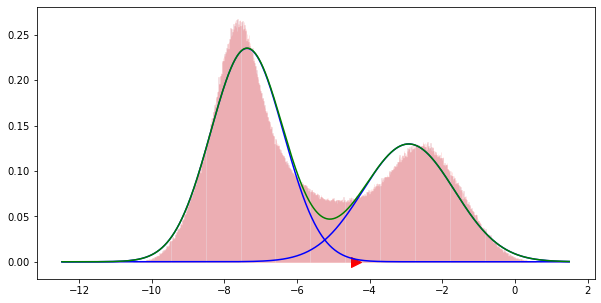

In [162]:
# Compute Threshold on noise:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
NoiseThresh,ax = bin.estimate_threshold_using_GMM(bin.smooth_residual,margin_std = 3, axis=ax)
print(NoiseThresh)

In [163]:
# Multiplicative Constrain: speed above SpeedThresh & noise below NoiseThresh 
tail_active1 = 1.0*(bin.low_pass_speed>SpeedThresh)#(bin.smooth_residual<NoiseThresh)
tail_active2 = 1.0*(bin.smooth_residual<NoiseThresh)
#np.logical_or(bin.smooth_residual>NoiseThresh,bin.low_pass_speed<SpeedThresh)
from AllSegmentationClass import find_onset_offset_numpy

tail_active = 1.0*((tail_active1+tail_active2)>0)
onset,offset,duration = find_onset_offset_numpy(tail_active)

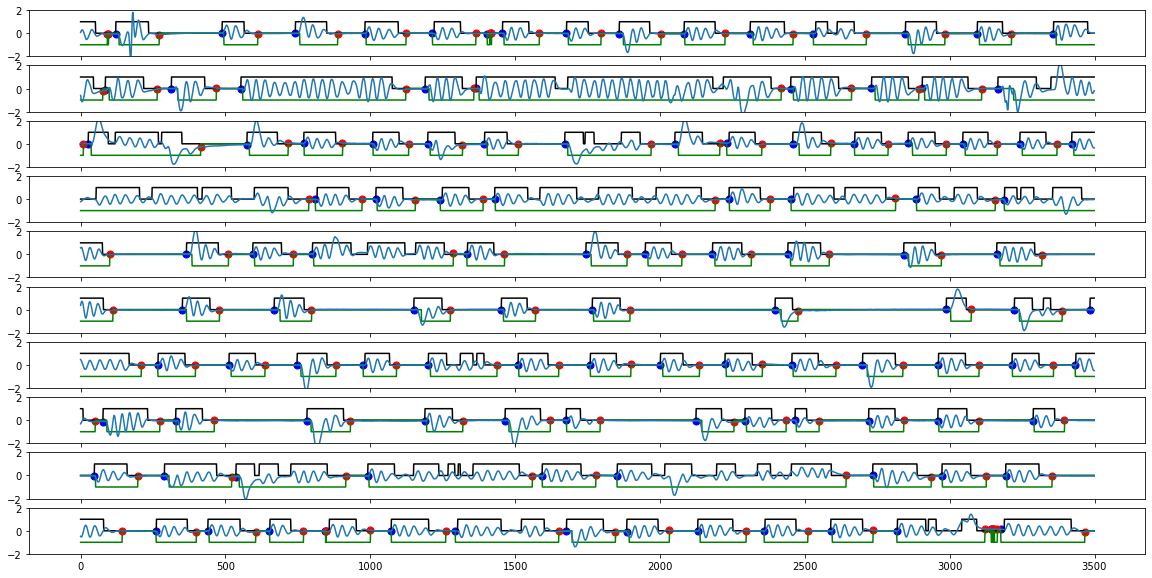

In [164]:
# Diagnostic Plot:
Duration = 700*5
s = tail.Reference_tail_segment_end
fig, (ax) = plt.subplots(10,1,figsize=(20,10), sharex=True)
for i in range(10):
    IdSt = np.random.randint(tail.T-Duration)
    ax[i].plot(tail_active1[IdSt:IdSt+Duration],'k')
    ax[i].plot(-tail_active2[IdSt:IdSt+Duration],'g')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')
    ax[i].plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
    ax[i].set_ylim(-2,2)
plt.show()

In [165]:
# Could be useful to add some cleanup to tail active:
# morphological opening to erode then dilate

In [166]:
from AllSegmentationClass import HalfBeat

In [167]:
HB = HalfBeat(tail_active,tail)

In [168]:
HB.find_slice(Min_Duration = 80,Min_IBI = 10)
HB.extract_half_beat(Half_BCFilt = 150, stdThres = 5,MinSizeBlob=400,Margin=10)

In [169]:
peaks_pos,peaks_neg = HB.half_beat_pos,HB.half_beat_neg

In [170]:
tail_active = HB.refine_bouts(MaxIBeatI = 40)
onset,offset,duration = find_onset_offset_numpy(tail_active)

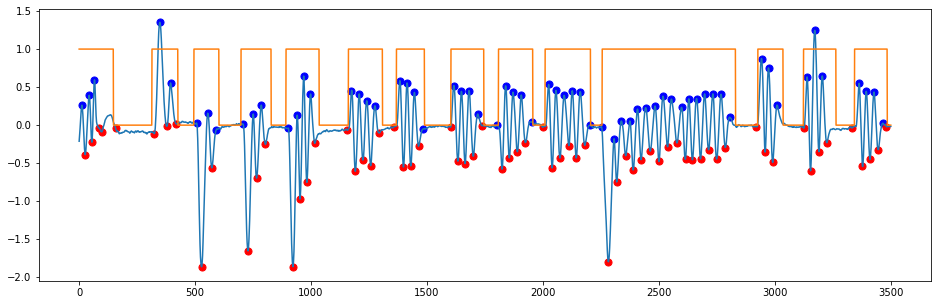

In [171]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(tail.T-Duration)
s = tail.Reference_tail_segment_end

fig, (ax) = plt.subplots(1,1,figsize=(16,5), sharex=True)

id = peaks_pos[(peaks_pos>IdSt)&(peaks_pos<(IdSt+Duration))]-IdSt
ax.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')

id = peaks_neg[(peaks_neg>IdSt)&(peaks_neg<(IdSt+Duration))]-IdSt
ax.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')

ax.plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
ax.plot(HB.tail_active_in[IdSt:IdSt+Duration])

plt.show()

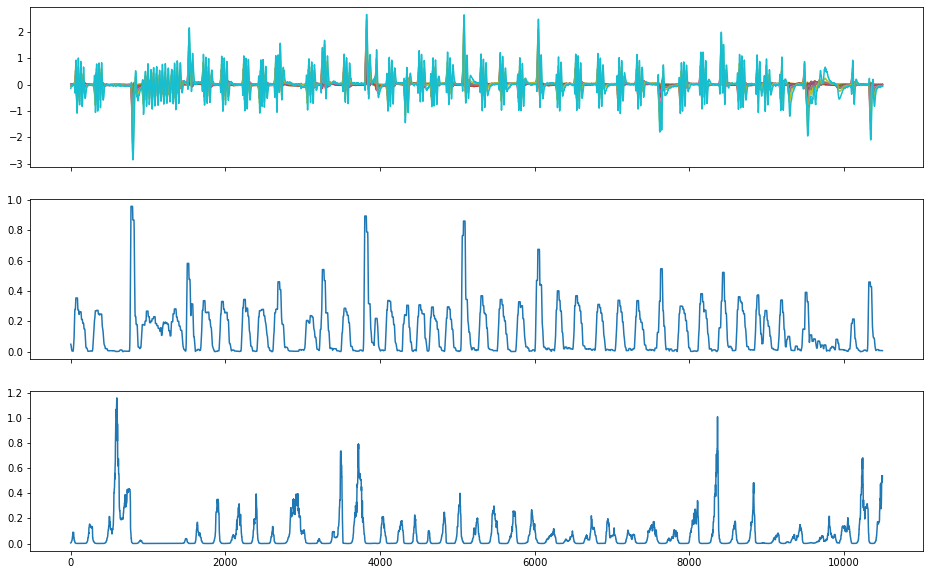

In [172]:

# Diagnostic Plot:
Duration = 700*15
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(3,1,figsize=(16,10), sharex=True)
ax[0].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])

ax[1].plot(bin.low_pass_speed[IdSt:IdSt+Duration])
ax[2].plot(bin.smooth_residual[IdSt:IdSt+Duration])

plt.show()

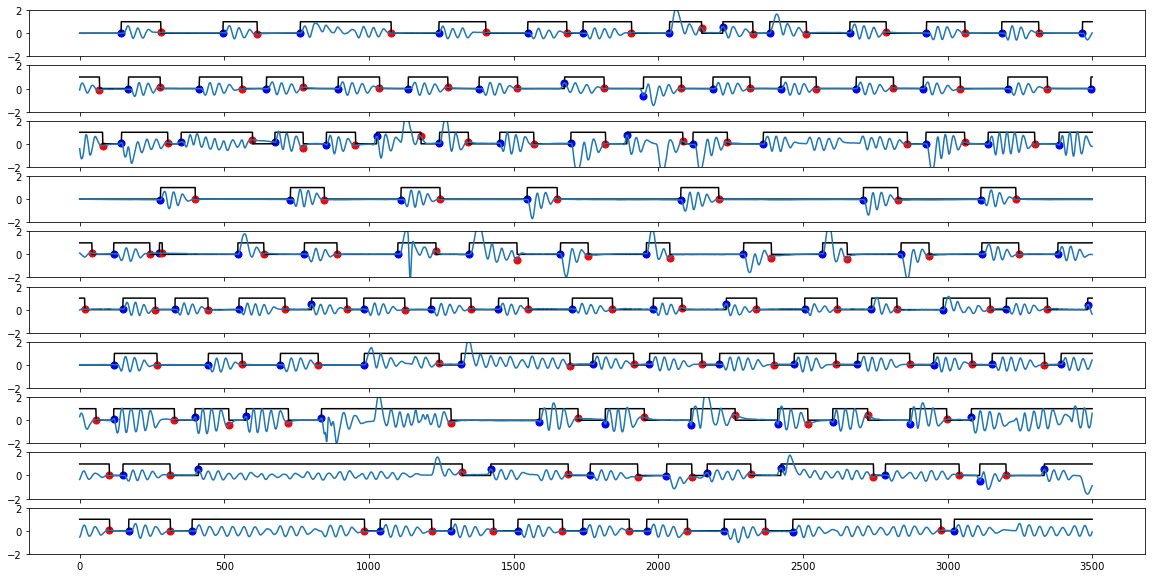

In [173]:
# Diagnostic Plot:
Duration = 700*5
s = tail.Reference_tail_segment_end
fig, (ax) = plt.subplots(10,1,figsize=(20,10), sharex=True)
for i in range(10):
    IdSt = np.random.randint(tail.T-Duration)
    ax[i].plot(tail_active[IdSt:IdSt+Duration],'k')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')
    ax[i].plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
    ax[i].set_ylim(-2,2)
plt.show()

# Autoregressive model on tail angle at reference segement:

In [174]:
tail_signal = tail.angle_smooth[:700*60*30,tail.Reference_tail_segment_end]

all_peaks = np.concatenate((HB.half_beat_pos,HB.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks[all_peaks<tail_signal.shape[0]]


In [175]:
from AllSegmentationClass import BreakPoint

In [176]:
breakpoint = BreakPoint()
L=4
peaks,likelihood_ratio = breakpoint.evaluate_break_point(tail_signal,L,onset,offset,all_peaks,margin_time=[90,30],sigma=None,method='costafast')

In [177]:
likelihood_ratio.shape

(5039,)

0.09667010277149757
12358.526806568858


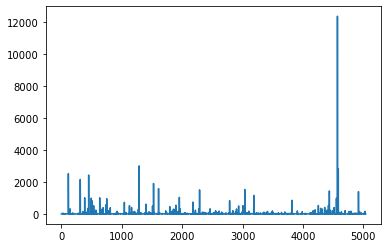

In [178]:
print(np.min(likelihood_ratio))
print(np.max(likelihood_ratio))
plt.plot(likelihood_ratio)
plt.show()

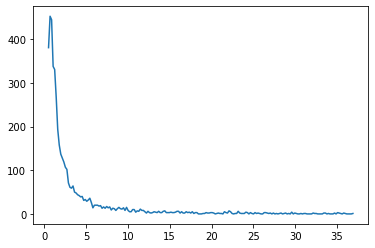

In [179]:
hist, bins = np.histogram(likelihood_ratio,range=(np.percentile(likelihood_ratio,5),np.percentile(likelihood_ratio,95)),bins = 200)
plt.plot(0.5*(bins[1:]+bins[0:-1]),hist)
plt.show()

In [180]:
print(np.percentile(likelihood_ratio,95))
Thresh = np.percentile(likelihood_ratio,95)

36.97889536723067


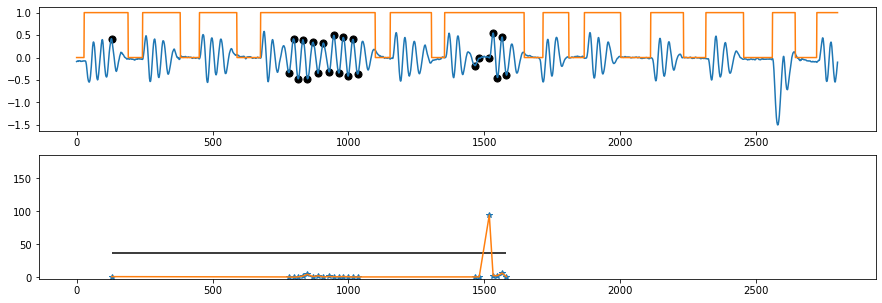

In [195]:
Duration = 700*4
while True:
    #IdSt = 2396873
    IdSt = 73262
    IdSt = np.random.randint(tail_signal.shape[0]-Duration)
    id = peaks[(peaks>IdSt)&(peaks<(IdSt+Duration))]-IdSt
    if len(id)>2:
        break

fig = plt.figure(figsize=(15,5))

s = tail.Reference_tail_segment_end
ax1 = plt.subplot(211)
ax1.plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
ax1.plot(tail_active[IdSt:IdSt+Duration])

#on_,off_ = onset[(onset>IdSt)&(onset<IdSt+Duration)],offset[(offset>IdSt)&(offset<IdSt+Duration)]
#on_,off_ = on_-IdSt,off_-IdSt
ax1.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='k')
#ax1.scatter(on_,np.zeros_like(on_),s=20,c='b')
#ax1.scatter(off_,np.zeros_like(off_),s=20,c='r')

ax2 = plt.subplot(212, sharex = ax1)
l = likelihood_ratio[(peaks>IdSt)&(peaks<(IdSt+Duration))]
ax2.plot(id,l,'*')
#ax2.stem(id,l)
ax2.plot(id,l)
ax2.hlines(Thresh,id[0],id[-1])

ax2.set_ylim(-2,Thresh*5)
plt.show()

In [200]:

all_peaks = np.concatenate((HB.half_beat_pos,HB.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks[all_peaks<tail_signal.shape[0]]

#peaks,likelihood_ratio
onset,offset,duration = find_onset_offset_numpy(tail_active[:tail_signal.shape[0]])

# Split bout
break_point = peaks[likelihood_ratio>Thresh]
likelihood_ratio_break_point = likelihood_ratio[likelihood_ratio>Thresh]


In [214]:
bouts_onset,bouts_offset = breakpoint.segment_from_breakpoint(onset,offset,all_peaks,break_point,likelihood_ratio_break_point,MinBoutDuration=60)

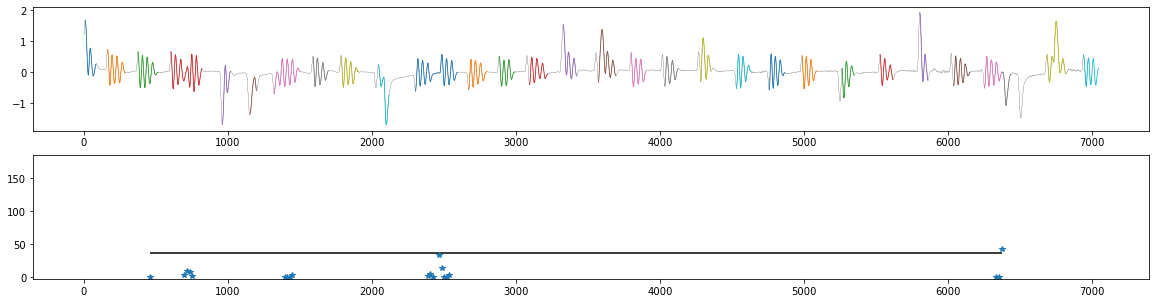

In [233]:
Duration = 700*10
IdSt = 300938# np.random.randint(tail_signal.shape[0]-Duration)
IdSt = np.random.randint(tail_signal.shape[0]-Duration)

fig = plt.figure(figsize=(20,5))

s = tail.Reference_tail_segment_end
ax1 = plt.subplot(211)
ax1.plot(tail.angle_smooth[IdSt:IdSt+Duration,s],lw=.2,c='k')
#ax1.plot(tail_active[IdSt:IdSt+Duration])

id = np.where((bouts_onset>IdSt)&(bouts_onset<IdSt+Duration))[0]
on_ = bouts_onset[id]
off_ = bouts_offset[id]
on_,off_ = on_-IdSt,off_-IdSt

for i1,i2 in zip(on_,off_):
    ax1.plot(np.arange(i1,i2),tail.angle_smooth[IdSt+i1:IdSt+i2,s],lw=.8)

id = peaks[(peaks>IdSt)&(peaks<(IdSt+Duration))]-IdSt
ax2 = plt.subplot(212, sharex = ax1)
l = likelihood_ratio[(peaks>IdSt)&(peaks<(IdSt+Duration))]
ax2.plot(id,l,'*')
ax2.hlines(Thresh,id[0],id[-1])

ax2.set_ylim(-2,Thresh*5)
plt.show()